In [1]:
import sionna.rt
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)


2025-06-13 09:25:02.711815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749806702.733308  395038 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749806702.739855  395038 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749806702.757450  395038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749806702.757472  395038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749806702.757474  395038 computation_placer.cc:177] computation placer alr

Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("GPU:", gpus)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("Using GPU:", gpus[0].name)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

else:
  print("No GPU found, using CPU.")



GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
Using GPU: /physical_device:GPU:0


I0000 00:00:1749806706.097021  395038 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13741 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# Load scene
scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

2025-06-13 09:25:08 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [ ]:
# open interactive window to preview the scene 
#scene.preview();


In [4]:

# check which materials are available in the scene
for name, obj in scene.objects.items():
    print(f'{name:<15}{obj.radio_material.name}')

no-name-1      ituf_glass
no-name-2      ituf_metal
Ceiling_Detail ituf_polystyrene
no-name-3      ituf_concrete
no-name-4      ituf_mdf


In [5]:
# adjust radio properties of the materials
# define callbacks to set conductivity and relative permittivity based on ITUF materials from hexa-x
def ituf_glass_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 6.2
  c, d = 0.005, 1.2
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_concrete_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.9
  c, d = 0.002, 1.3
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_metal_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.0  
  c, d = 10**7, 0.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_polystyrene_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.05 #eta_r
  c, d = 0.000008, 1.1
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

def ituf_mdf_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 2.0 #eta_r
  c, d = 0.005, 1.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

# add callbacks to the materials
# polystyrene
ceiling_object = scene.get("Ceiling_Detail")
ceiling_object.radio_material.frequency_update_callback = ituf_polystyrene_callback
print(ceiling_object.radio_material.name)
print(ceiling_object.radio_material.frequency_update_callback)

# no-name-1 => ituf_glass
glass_objects = scene.get("no-name-1")
glass_objects.radio_material.frequency_update_callback = ituf_glass_callback
print(glass_objects.radio_material.name)
print(glass_objects.radio_material.frequency_update_callback)

# no-name-2 => ituf_concrete
concrete_objects = scene.get("no-name-2")
concrete_objects.radio_material.frequency_update_callback = ituf_concrete_callback
print(concrete_objects.radio_material.name)
print(concrete_objects.radio_material.frequency_update_callback)

# no-name-3 => ituf_metal
metal_objects = scene.get("no-name-3")
metal_objects.radio_material.frequency_update_callback = ituf_metal_callback
print(metal_objects.radio_material.name)
print(metal_objects.radio_material.frequency_update_callback)

# no-name-4 => ituf_mdf
metal_mdf = scene.get("no-name-4")
metal_mdf.radio_material.frequency_update_callback = ituf_mdf_callback
print(metal_mdf.radio_material.name)
print(metal_mdf.radio_material.frequency_update_callback)


ituf_polystyrene
<function ituf_polystyrene_callback at 0x742e0951f380>
ituf_glass
<function ituf_glass_callback at 0x742e0951f100>
ituf_metal
<function ituf_concrete_callback at 0x742e0951efc0>
ituf_concrete
<function ituf_metal_callback at 0x742e0951ee80>
ituf_mdf
<function ituf_mdf_callback at 0x742e0951e980>


In [6]:
# check conductivity and relative permittivity at different frequencies
# loop through material names and print them
sub_GHz = 3.5e9
sub_THz = 170e9
# todo set values at 170 GHZ
for key, value in scene.objects.items():
    print(f'---------------{key=}----------------')
    # Print name of assigned radio material for different frequenies
    for f in [sub_GHz, sub_THz]: # Print for differrent frequencies
        scene.frequency = f
        value.radio_material.frequency_update() # update the frequency of the objects
        print(f"\nRadioMaterial: {value.radio_material.name} @ {scene.frequency/1e9}GHz")
        print("Conductivity:", value.radio_material.conductivity.numpy())
        print("Relative permittivity:", value.radio_material.relative_permittivity.numpy())
        print("Scattering coefficient:", value.radio_material.scattering_coefficient.numpy())
        print("XPD coefficient:", value.radio_material.xpd_coefficient.numpy())




---------------key='no-name-1'----------------

RadioMaterial: ituf_glass @ [3.5]GHz
Conductivity: [0.02248287]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_glass @ [170]GHz
Conductivity: [2.3741536]
Relative permittivity: [6.2]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='no-name-2'----------------

RadioMaterial: ituf_metal @ [3.5]GHz
Conductivity: [0.01019339]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_metal @ [170]GHz
Conductivity: [1.5871336]
Relative permittivity: [1.9]
Scattering coefficient: [0.]
XPD coefficient: [0.]
---------------key='Ceiling_Detail'----------------

RadioMaterial: ituf_polystyrene @ [3.5]GHz
Conductivity: [3.1736927e-05]
Relative permittivity: [1.05]
Scattering coefficient: [0.]
XPD coefficient: [0.]

RadioMaterial: ituf_polystyrene @ [170]GHz
Conductivity: [0.00227292]
Relative permittivity: [1.05]
Scattering coefficie

In [ ]:


# todo change because this is in y-z plane
N_antennas = 4 # Number of antennas in each direction (x and y)
scene.tx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern="iso",
                            polarization="cross")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_antennas,
                             num_cols=N_antennas,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="cross")


"""  check the coordinates of the zones """
# global zone: red
z_height = 2
x_start = 1.08
x_stop = 9.34
y_start = 1.88
y_stop = 24.89
testpoints = [[x_start, y_start, z_height], [x_stop, y_start, z_height], [x_start, y_stop, z_height], [x_stop, y_stop, z_height] ]
for idx, testpoint in enumerate(testpoints):
    tx = Transmitter(name=f"testpoint_{idx}",
                        position=testpoint,
                        display_radius=1,
                        color=[1, 0, 0])

    # Add RU transmitter instance to scene
    scene.add(tx)

# zone 1 pink
x_zone1_start = 4.9
x_zone1_stop = x_stop
y_zone1_start = y_start
y_zone1_stop = y_stop
zone_one_points = [[x_zone1_start, y_zone1_start, z_height], [x_zone1_start, y_zone1_stop, z_height]]
for idx, zone_one_point in enumerate(zone_one_points):
    rx = Receiver(name=f"zone1_testpoint_{idx}",
                        position=zone_one_point,
                        display_radius=1,
                        color=[1, 0, 0.984])

    # Add RU transmitter instance to scene
    scene.add(rx)

# zone 2 blue
x_zone2_start = x_start
x_zone2_stop = x_zone1_start
y_zone2_start = 5.51
y_zone2_stop = 14.2
zone_2_points = [[x_zone2_start, y_zone2_start, z_height], [x_zone2_start, y_zone2_stop, z_height],
                 [x_zone2_stop, y_zone2_start, z_height], [x_zone2_stop, y_zone2_stop, z_height]]
for idx, zone_2_point in enumerate(zone_2_points):
    rx = Receiver(name=f"zone2_testpoint_{idx}",
                        position=zone_2_point,
                        display_radius=1,
                        color=[0, 0.604, 1])

    # Add RU transmitter instance to scene
    scene.add(rx)

# zone 3 orange
x_zone3_start = x_start
x_zone3_stop = x_zone1_start
y_zone3_start = 15.6
y_zone3_stop = 23.65
zone_3_points = [[x_zone3_start, y_zone3_start, z_height], [x_zone3_start, y_zone3_stop, z_height],
                 [x_zone3_stop, y_zone3_start, z_height], [x_zone3_stop, y_zone3_stop, z_height]]
for idx, zone_3_point in enumerate(zone_3_points):
    rx = Receiver(name=f"zone3_testpoint_{idx}",
                        position=zone_3_point,
                        display_radius=1,
                        color=[1, 0.651, 0])

    # Add RU transmitter instance to scene
    scene.add(rx)


# zone 4 purple
x_zone4_start = x_start
x_zone4_stop = x_zone1_start
y_zone4_start = y_start
y_zone4_stop = 4.19
zone_4_points = [[x_zone4_start, y_zone4_start, z_height], [x_zone4_start, y_zone4_stop, z_height],
                 [x_zone4_stop, y_zone4_start, z_height], [x_zone4_stop, y_zone4_stop, z_height]]
for idx, zone_4_point in enumerate(zone_4_points):
    rx = Receiver(name=f"zone4_testpoint_{idx}",
                        position=zone_4_point,
                        display_radius=1,
                        color=[0.506, 0, 1])

    # Add RU transmitter instance to scene
    scene.add(rx)


# # Create sub-THz stripes
# stripe_start_pos = [2, 2.5, 3.5]
# N_RUs = 1 #40 # todo adjust to size of the room (along y axis)
# N_stripes = 1 #10 # todo adjust to size of the room (alang x axis)
# space_between_RUs = 0.5 # in meters
# space_between_stripses = 0.5 # in meters
# for stripe_idx in range(N_stripes):
#     for RU_idx in range(N_RUs):
#         # compute RU position
#         tx_pos = [stripe_start_pos[0] + stripe_idx * space_between_stripses,
#                   stripe_start_pos[1] + RU_idx * space_between_RUs,
#                   stripe_start_pos[2]]
        
#         tx = Transmitter(name=f"tx_stripe_{stripe_idx}_RU_{RU_idx}",
#                         position=tx_pos,
#                         display_radius=0.2)

#         # Add RU transmitter instance to scene
#         scene.add(tx)

#         # Point the transmitter downwards
#         tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards

# # Create a receiver
# rx_pos = [7, 10, 1]
# rx = Receiver(name="rx",
#               position=rx_pos,
#               display_radius=1)

# # Add receiver instance to scene
# scene.add(rx)




In [8]:
scene.preview();

In [ ]:
""" todo test location of UEs """



subcarrier spacing = 0.3814697265625 MHz
 own faxis = faxis = [151.5, 151.5, 151.501, .. 32762 skipped .., 163.999, 163.999, 164] GHz
 builtin faxis = faxis = [-6.25, -6.24962, -6.24924, .. 32762 skipped .., 6.24886, 6.24924, 6.24962] GHz
Time to compute paths: 1.88 seconds
Shape of h_freq:  (1, 32, 1, 32, 1, 32768)
 builtin faxis = faxis = [-6.25, -6.24962, -6.24924, .. 32762 skipped .., 6.24886, 6.24924, 6.24962] GHz


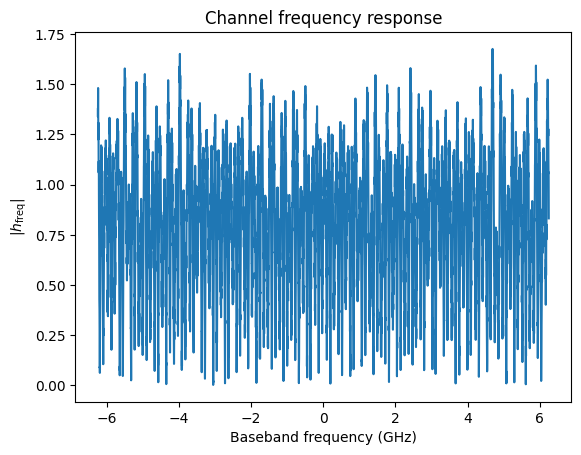

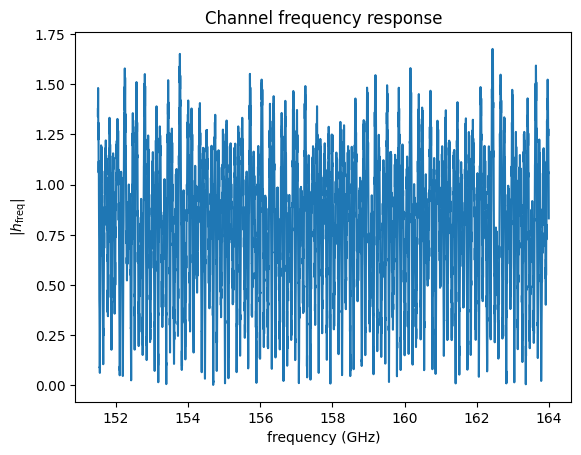

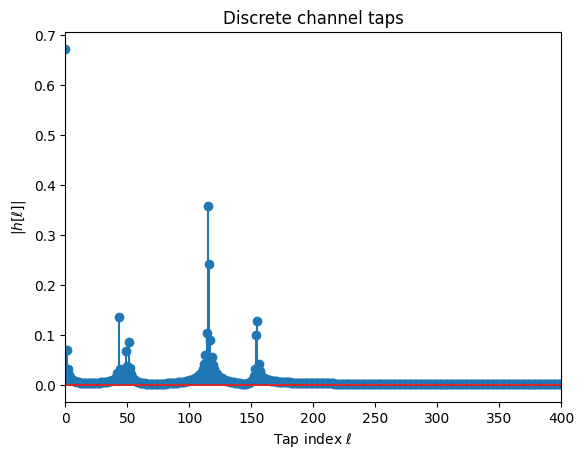

Shape of taps:  (1, 32, 1, 32, 1, 32768)
diff = taps - htime = [0.00240429 0.13851199 0.0001414  ... 0.02218319 0.03201903 0.05980443]
taps = [ 1.9718145e-01-6.4468217e-01j  2.3057494e-02-6.5450095e-02j
 -1.2075212e-02+2.9903159e-02j ... -5.4500956e-06-7.4294248e-06j
  5.4565717e-06+7.4343002e-06j -5.4564039e-06-7.4340728e-06j]
htime = [ 0.19649483-0.64237801j -0.02295121+0.06519741j -0.01200849+0.02977849j
 ...  0.00417061-0.021794j    0.00705994-0.0312248j
  0.0152728 -0.05782736j]


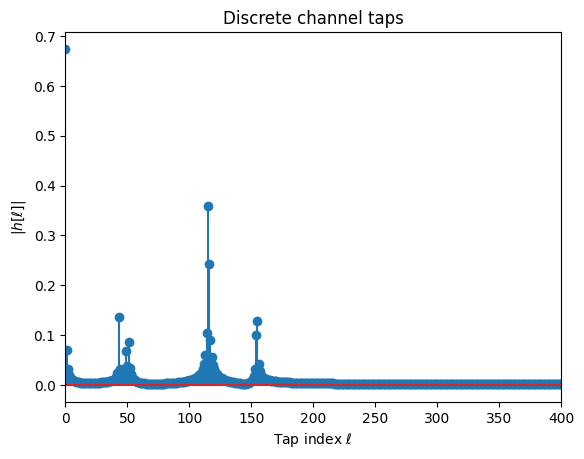

In [50]:
scene.frequency = 157.75e9 # Set frequency to 170 GHz
# implicityly updates radio material properties

# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# OFDM system parameters
BW = 12.5e9 # Bandwidth of the system
num_subcarriers = 2**15 #=32768
subcarrier_spacing= BW / num_subcarriers
f_axis = scene.frequency - BW/2 + subcarrier_spacing * np.arange(num_subcarriers)  # array of frequencies
print(f'subcarrier spacing = {subcarrier_spacing/1e6} MHz')
print(f' own faxis = faxis = {f_axis/1e9} GHz')

# Compute propagation paths
t1 = time.time()
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)


# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)
print(f' builtin faxis = faxis = {frequencies/1e9} GHz')


# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

t2 = time.time()
print(f"Time to compute paths: {t2-t1:.2f} seconds")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)
print(f' builtin faxis = faxis = {frequencies/1e9} GHz')

# Plot absolute value
habs = np.abs(h_freq)[0,0,0,0,0,:]
plt.figure()
plt.plot(np.squeeze(frequencies)/1e9, np.squeeze(habs));
plt.xlabel("Baseband frequency (GHz)");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

plt.figure()
plt.plot(np.squeeze(f_axis)/1e9, np.squeeze(habs));
plt.xlabel("frequency (GHz)");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");
plt.show()


# sanity check to see if time representation is ok
htime = np.fft.ifft(h_freq[0,0,0,0,0,:], axis=-1) # check if it works
plt.stem(np.abs(htime))
plt.xlim(0, 400) # Limit x-axis to first 100 taps

plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");
plt.show()


taps = paths.taps(bandwidth=BW, # Bandwidth to which the channel is low-pass filtered 100MHé
                  l_min=0,        # Smallest time lag
                  l_max=num_subcarriers-1,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.abs(taps)[0,0,0,0,0]);
plt.xlim(0, 400) # Limit x-axis to first 100 taps
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

print(f'diff = taps - htime = {np.abs(taps[0, 0, 0, 0, 0] - htime)}')

print(f'taps = {taps[0, 0, 0, 0, 0]}')
print(f'htime = {htime}')

In [11]:
scene.preview(paths=paths, clip_at=20);

Shape of taps:  (1, 32, 1, 32, 1, 407)


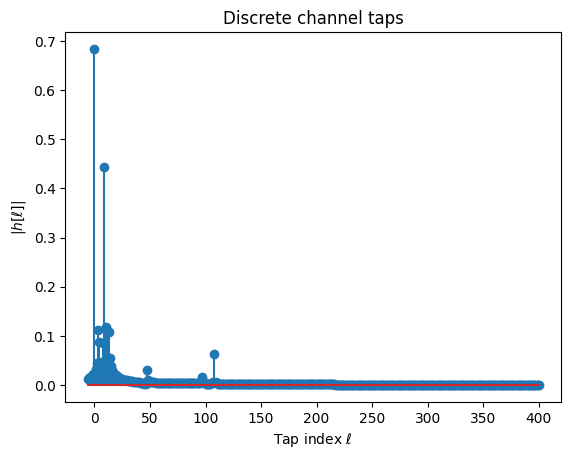

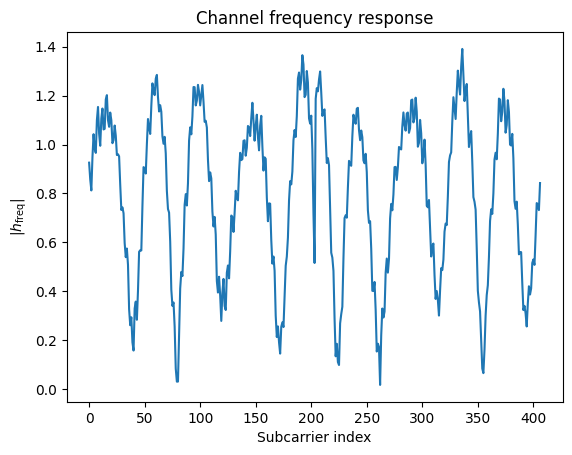

In [12]:
taps = paths.taps(bandwidth=1e9, # Bandwidth to which the channel is low-pass filtered 100MHé
                  l_min=-6,        # Smallest time lag
                  l_max=400,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 401), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

# take fft to see frequency response
taps_fft = np.fft.fft(taps, axis=-1)

# Plot absolute value
plt.figure()
plt.plot(np.abs(taps_fft)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");


bw = 0.98304 GHz
Shape of h_freq:  (1, 32, 1, 32, 1, 32768)
taps_check shape: (32768,)


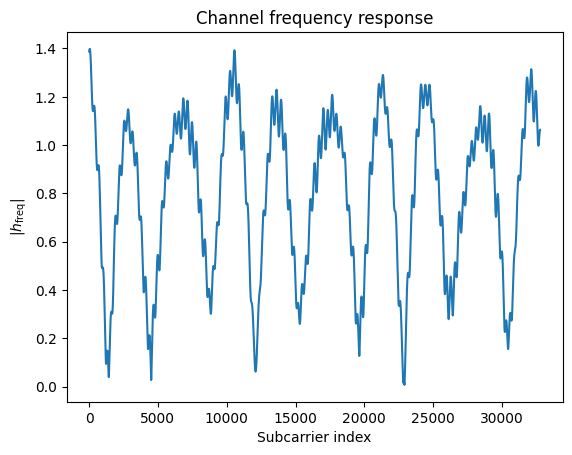

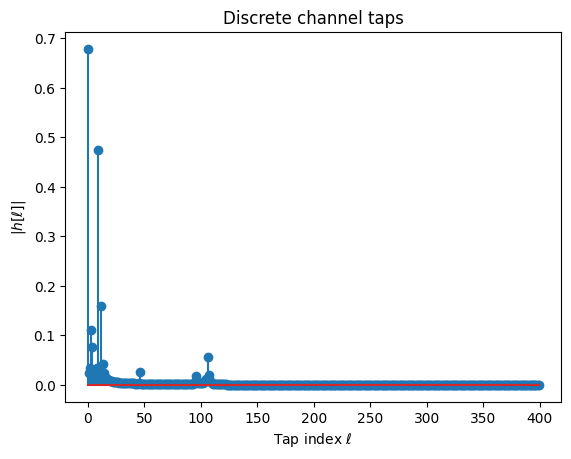

In [13]:
# check if we get frequency response and take ifft if we get the same thing!

# OFDM system parameters
num_subcarriers = 2**15 #1024
subcarrier_spacing=30e3
bw = num_subcarriers * subcarrier_spacing 
print(f'bw = {bw/1e9} GHz')

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

taps_check = np.fft.ifft(h_freq[0,0,0,0,0,:], axis=-1) # Inverse FFT to get taps
print(f'taps_check shape: {taps_check.shape}')
plt.figure()
l = 400
plt.stem(np.arange(l), np.abs(taps_check[0:l]));
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");